<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [54]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from itertools import chain

In [55]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)
    
    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [56]:
def train_classifier_XGB(X_train, y_train): 
    xgb = XGBClassifier(use_label_encoder=False, eta = 0.7, max_depth= 19, subsample = 0.7, verbosity = 0)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return xgb, ttimes

In [57]:
def train_classifier_DNN(X_train, y_train): 
    size = (10,) * 3
    dnn = MLPClassifier(hidden_layer_sizes=size, activation='logistic',
                                solver='adam', learning_rate='invscaling', max_iter=1000)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return dnn, ttimes

In [58]:
def train_classifier_KNN(X_train, y_train): 
    knn = KNeighborsClassifier(leaf_size=21, p=2, n_neighbors=4)
    
    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return knn, ttimes

In [59]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 

In [60]:
windowrange=list(chain(range(10,101,10), range(200,3601,100)))
spacingrange=[1]

A_XGB = np.zeros([len(spacingrange),len(windowrange)])
GP_XGB = np.zeros([len(spacingrange),len(windowrange)])
GR_XGB = np.zeros([len(spacingrange),len(windowrange)])
GF1_XGB = np.zeros([len(spacingrange),len(windowrange)])

A_DNN = np.zeros([len(spacingrange),len(windowrange)])
GP_DNN = np.zeros([len(spacingrange),len(windowrange)])
GR_DNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_DNN = np.zeros([len(spacingrange),len(windowrange)])

A_KNN = np.zeros([len(spacingrange),len(windowrange)])
GP_KNN = np.zeros([len(spacingrange),len(windowrange)])
GR_KNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_KNN = np.zeros([len(spacingrange),len(windowrange)])

def training_loop(windowrange, spacingrange):
    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xgb_all_ttimes = []
    dnn_all_ttimes = []
    knn_all_ttimes = []
    
    lbl = [0, 1]
    label_names=['Attenuation', 'Filtering']

    for i, spacing in enumerate(spacingrange): #enumerate(range(minsp,maxsp+1,stepsp)):
        for j, length in enumerate(windowrange): #enumerate(range(minlength,maxlength+1,steplength)):
            print('********************************')
            print('Iteration for spacing={} and window length={}'.format(spacing,length))

            ####### 1) Load dataset #######
            print('1) Loading dataset into (XX,yy)...')

            XX = None
            yy = None
            folderpath='../Features_raw'

            for filename in os.listdir(folderpath):
                if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
                    label = 0
                    if int(filename[9]) > 5:
                        label = 1
                    fullname = folderpath + '/' + filename
                    XX, yy = load_window_dataset(XX, yy, fullname, label)

            scaler = StandardScaler()
            XX = scaler.fit_transform(XX)

            X_train, X_test, y_train, y_test = train_test_split(XX, yy, stratify=yy, test_size=0.3, random_state=42)
            print('Training XGB...')
            xgb, xgb_ttimes = train_classifier_XGB(X_train, y_train)

            print('Training DNN...')
            dnn, dnn_ttimes = train_classifier_DNN(X_train, y_train)

            print('Training KNN...')
            knn, knn_ttimes = train_classifier_KNN(X_train, y_train)

            xgb_all_ttimes.append(xgb_ttimes)
            dnn_all_ttimes.append(dnn_ttimes)
            knn_all_ttimes.append(knn_ttimes)

            y_pred_XGB = xgb.predict(X_test)
            y_pred_DNN = dnn.predict(X_test)
            y_pred_KNN = knn.predict(X_test)

            A_XGB[i,j], GP_XGB[i,j], GR_XGB[i,j], GF1_XGB[i,j] = performance_eval(y_test, y_pred_XGB, lbl, label_names)
            A_DNN[i,j], GP_DNN[i,j], GR_DNN[i,j], GF1_DNN[i,j] = performance_eval(y_test, y_pred_DNN, lbl, label_names)
            A_KNN[i,j], GP_KNN[i,j], GR_KNN[i,j], GF1_KNN[i,j] = performance_eval(y_test, y_pred_KNN, lbl, label_names)

    return xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes

In [90]:
def candle_trainng_size_impact(fig_folder, alg_name, ttimes, windowrange, spacingrange):
    if len(spacingrange) == 1:
        considered_range = windowrange
        valutation_type = 'Window length'
    else:
        considered_range = spacingrange
        valutation_type = 'Spacing length'
        
    fig, ax = plt.subplots(figsize=(15,8))
    bplots = []
    n_perc = len(considered_range)
    
    for i in range(n_perc):
        bplots.append(ax.boxplot(ttimes[i], positions = [i], patch_artist=True))

    for bplot in bplots:
        for patch in bplot['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xticks(ticks = list(range(n_perc)), labels = [str(x) for x in considered_range], fontsize = 14)
    plt.setp(ax.xaxis.get_majorticklabels(), ha="center") 
    plt.ylabel('Seconds', color='black', fontsize=14)
    title=alg_name+' '+ valutation_type+' impact on Traning Time with '
    if len(windowrange) == 1:
        title = title + 'W=' + str(windowrange[0])
    else:
        title = title + 'S=' + str(spacingrange[0])
        
    plt.title(title, fontsize=14)
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
    plt.show()
    fig.savefig(fig_folder+'/'+title.replace(" ", "_")+'.png')

In [63]:
fig_folder = '1_7_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

windowrange=list(chain(range(10,101,10), range(200,3601,100)))
spacingrange=[1]
xgb_all_ttimes, dnn_all_ttimes, knn_all_ttimes = training_loop(windowrange, spacingrange)

********************************
Iteration for spacing=1 and window length=10
1) Loading dataset into (XX,yy)...
Training XGB...
12.602144241333008
15.293639421463013
16.034688234329224
Training DNN...
17.19960880279541
15.763629674911499
16.331599473953247
Training KNN...
0.12054109573364258
0.12702322006225586
0.10995864868164062
********************************
Iteration for spacing=1 and window length=20
1) Loading dataset into (XX,yy)...
Training XGB...
9.037700653076172
9.05397343635559
9.235881805419922
Training DNN...
13.839154720306396
15.688467741012573
14.311006784439087
Training KNN...
0.12403583526611328
0.11057710647583008
0.1259152889251709
********************************
Iteration for spacing=1 and window length=30
1) Loading dataset into (XX,yy)...
Training XGB...
7.256330728530884
7.782488822937012
7.752999782562256
Training DNN...
15.441044807434082
14.732894897460938
14.163460731506348
Training KNN...
0.10113930702209473
0.13065457344055176
0.12890338897705078
****

13.909258127212524
17.425528287887573
Training KNN...
0.1138308048248291
0.11723494529724121
0.12389564514160156
********************************
Iteration for spacing=1 and window length=1700
1) Loading dataset into (XX,yy)...
Training XGB...
4.703221797943115
4.496571063995361
4.6772894859313965
Training DNN...
20.249279737472534
15.323119878768921
16.18861174583435
Training KNN...
0.10287237167358398
0.11405658721923828
0.10453438758850098
********************************
Iteration for spacing=1 and window length=1800
1) Loading dataset into (XX,yy)...
Training XGB...
4.312942981719971
4.417240619659424
4.391080379486084
Training DNN...
16.482908248901367
13.668813705444336
15.010732412338257
Training KNN...
0.10683250427246094
0.09314084053039551
0.10983490943908691
********************************
Iteration for spacing=1 and window length=1900
1) Loading dataset into (XX,yy)...
Training XGB...
4.241398334503174
4.617244005203247
4.403336048126221
Training DNN...
14.152338743209839

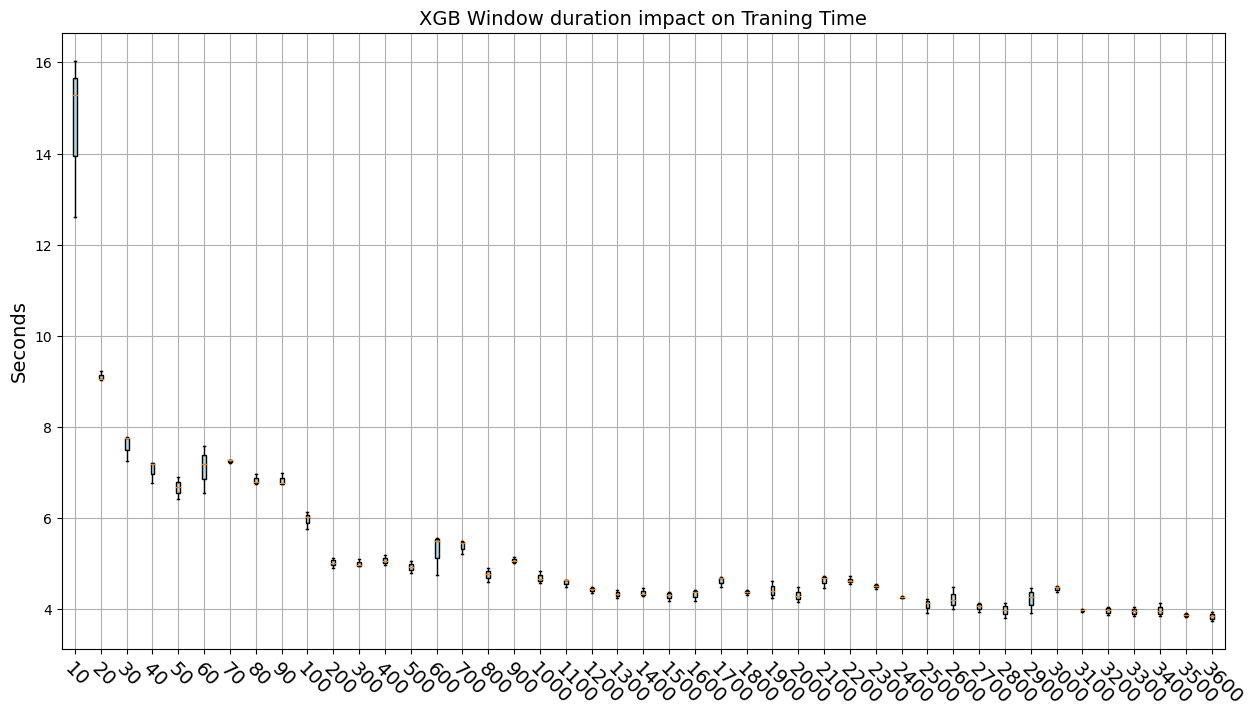

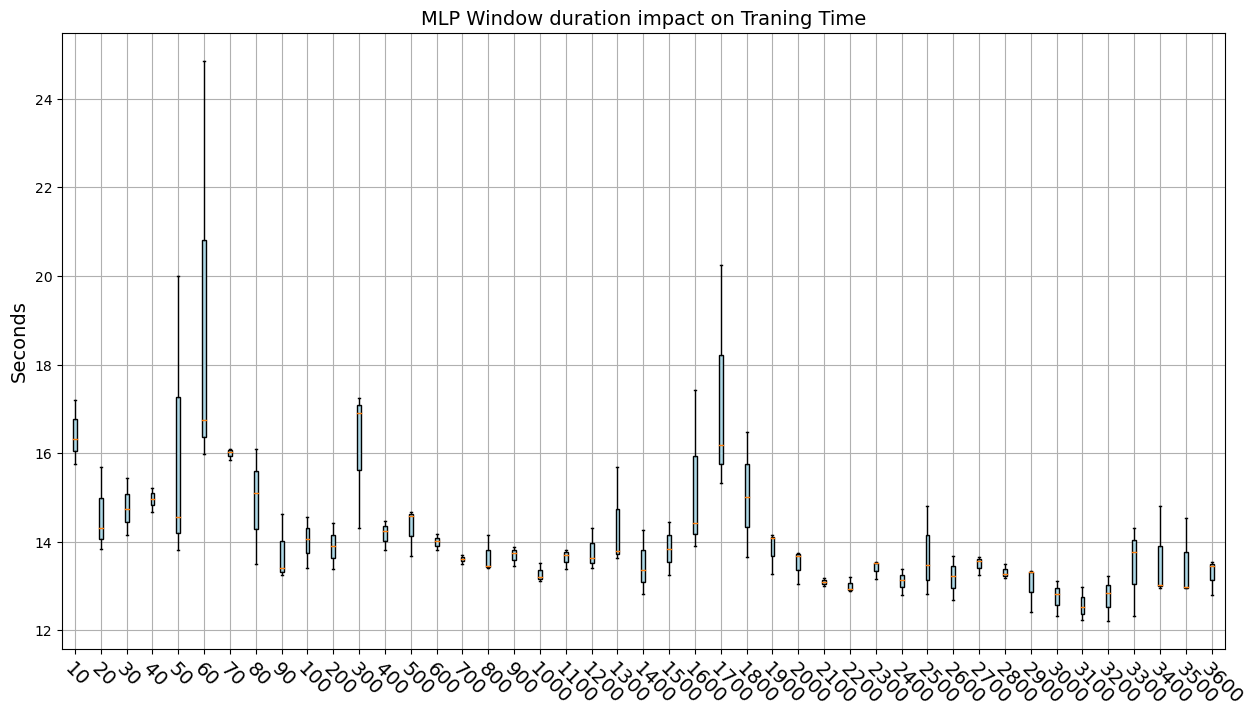

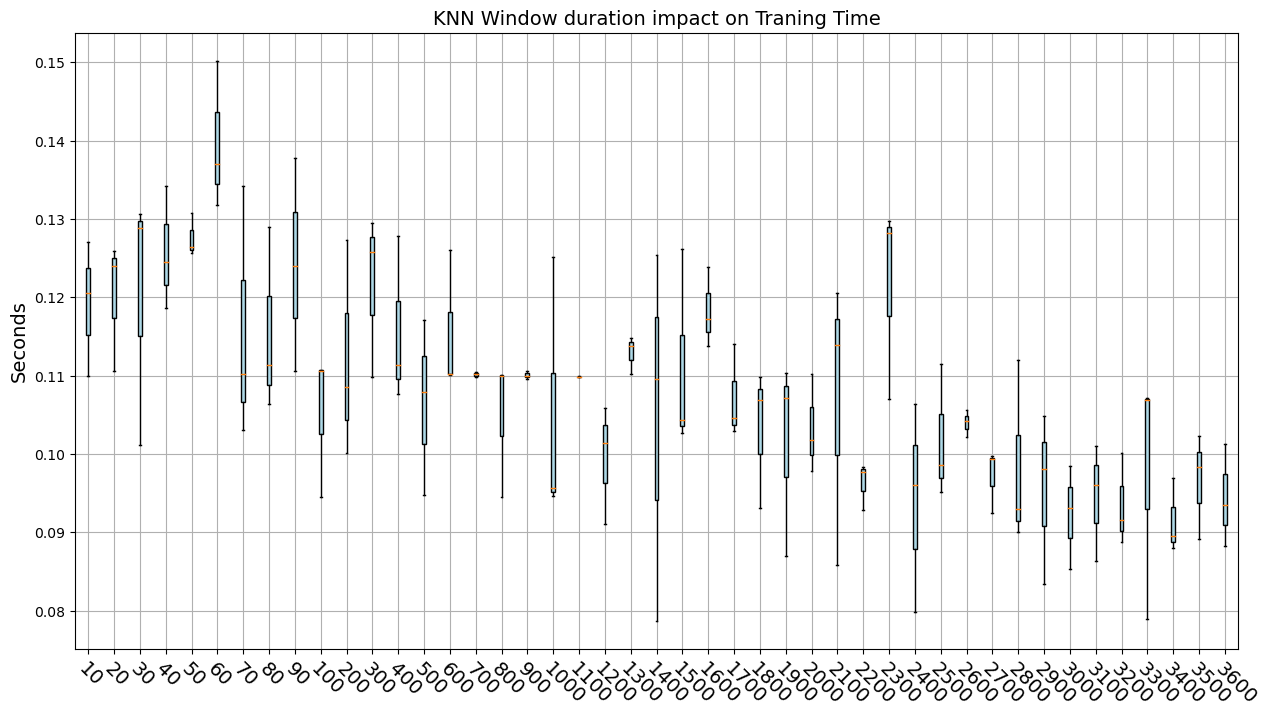

In [66]:
candle_trainng_size_impact(fig_folder, 'XGB', xgb_all_ttimes, windowrange)
candle_trainng_size_impact(fig_folder, 'MLP', dnn_all_ttimes, windowrange)
candle_trainng_size_impact(fig_folder, 'KNN', knn_all_ttimes, windowrange)

In [84]:
###############################################################################
###### Windows
###############################################################################

def draw_summary_plot(fig_folder, a_limit, b_limit, windowrange, spacingrange):

    global A_XGB, GP_XGB, GR_XGB, GF1_XGB
    global A_DNN, GP_DNN, GR_DNN, GF1_DNN
    global A_KNN, GP_KNN, GR_KNN, GF1_KNN
    
    xvalues = None
    if len(windowrange) == 1:
        xvalues=np.array(spacingrange)
        subject = 'Spacing'
    else:
        xvalues=np.array(windowrange)
        subject = 'Window'

    A_XGB = A_XGB.reshape(-1, 1)
    GP_XGB = GP_XGB.reshape(-1, 1)
    GR_XGB = GR_XGB.reshape(-1, 1)
    GF1_XGB = GF1_XGB.reshape(-1, 1)

    A_DNN = A_DNN.reshape(-1, 1)
    GP_DNN = GP_DNN.reshape(-1, 1)
    GR_DNN = GR_DNN.reshape(-1, 1)
    GF1_DNN = GF1_DNN.reshape(-1, 1)

    A_KNN = A_KNN.reshape(-1, 1)
    GP_KNN = GP_KNN.reshape(-1, 1)
    GR_KNN = GR_KNN.reshape(-1, 1)
    GF1_KNN = GF1_KNN.reshape(-1, 1)

    fig, axs = plt.subplots(2, 2, sharex='all', figsize=(20,15))

    axs[0,0].plot(xvalues[a_limit:b_limit], A_XGB[a_limit:b_limit], label = 'XGB')
    axs[0,0].plot(xvalues[a_limit:b_limit], A_DNN[a_limit:b_limit], label = 'DNN')
    axs[0,0].plot(xvalues[a_limit:b_limit], A_KNN[a_limit:b_limit], label = 'KNN')
    axs[0,0].set_xticks(xvalues)
    axs[0,0].tick_params(labelrotation=55)
    axs[0,0].set_title('Accuracy')
    axs[0,0].set_ylabel('Accuracy')
    axs[0,0].yaxis.grid(True)

    axs[0,1].plot(xvalues[a_limit:b_limit], GP_XGB[a_limit:b_limit], label = 'XGB')
    axs[0,1].plot(xvalues[a_limit:b_limit], GP_DNN[a_limit:b_limit], label = 'DNN')
    axs[0,1].plot(xvalues[a_limit:b_limit], GP_KNN[a_limit:b_limit], label = 'KNN')
    axs[0,1].set_title('Precision')
    axs[0,1].set_ylabel('Precision')
    axs[0,1].tick_params(labelrotation=55)
    axs[0,1].yaxis.grid(True)

    axs[1,0].plot(xvalues[a_limit:b_limit], GR_XGB[a_limit:b_limit], label = 'XGB')
    axs[1,0].plot(xvalues[a_limit:b_limit], GR_DNN[a_limit:b_limit], label = 'DNN')
    axs[1,0].plot(xvalues[a_limit:b_limit], GR_KNN[a_limit:b_limit], label = 'KNN')
    axs[1,0].set_title('Recall')
    axs[1,0].set_ylabel('Recall')
    axs[1,0].tick_params(labelrotation=55)
    axs[1,0].yaxis.grid(True)

    axs[1,1].plot(xvalues[a_limit:b_limit], GF1_XGB[a_limit:b_limit], label = 'XGB')
    axs[1,1].plot(xvalues[a_limit:b_limit], GF1_DNN[a_limit:b_limit], label = 'DNN')
    axs[1,1].plot(xvalues[a_limit:b_limit], GF1_KNN[a_limit:b_limit], label = 'KNN')
    axs[1,1].set_title('F1-Score')
    axs[1,1].set_ylabel('F1-Score')
    axs[1,1].tick_params(labelrotation=55)
    axs[1,1].yaxis.grid(True)

    axs[1,0].set_xlabel(subject+' length, s')
    axs[1,1].set_xlabel(subject+' length, s')

    axs[1,1].legend(loc='best')

    title = 'Impact of ' + subject + ' length with '
    if len(windowrange) == 1:
        title = title + 'W=' + str(windowrange[0])
    else:
        title = title + 'S=' + str(spacingrange[0])
    
    fig.suptitle(title)
    
    fig.tight_layout()
    fig.savefig(fig_folder+'/'+str(a_limit)+'_'+str(b_limit)+'_'+subject+'_duration.png')

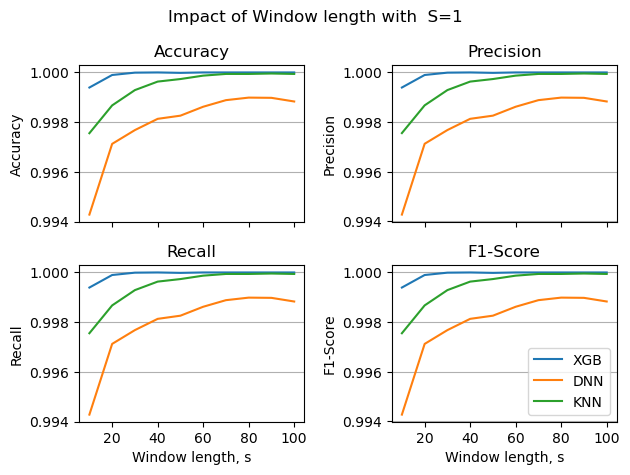

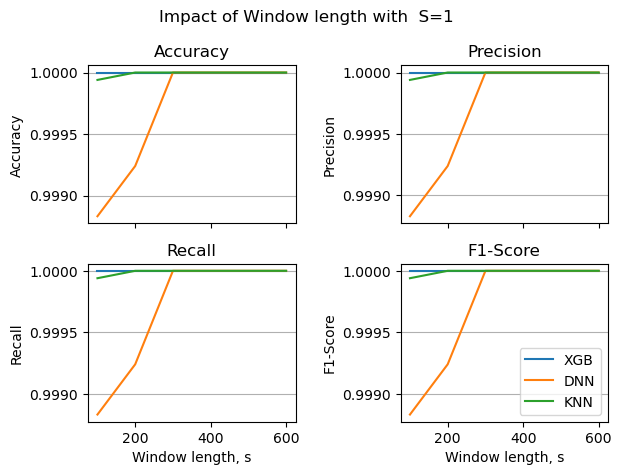

In [75]:
# Window Specific view
draw_summary_plot(fig_folder, 0, 10, windowrange, spacingrange)

# Window Global view
draw_summary_plot(fig_folder, 9, 15, windowrange, spacingrange)

In [77]:
###############################################################################
###### Spacing
###############################################################################
windowrange=[80]
spacingrange=list(range(10,161,10))

A_XGB = np.zeros([len(spacingrange),len(windowrange)])
GP_XGB = np.zeros([len(spacingrange),len(windowrange)])
GR_XGB = np.zeros([len(spacingrange),len(windowrange)])
GF1_XGB = np.zeros([len(spacingrange),len(windowrange)])

A_DNN = np.zeros([len(spacingrange),len(windowrange)])
GP_DNN = np.zeros([len(spacingrange),len(windowrange)])
GR_DNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_DNN = np.zeros([len(spacingrange),len(windowrange)])

A_KNN = np.zeros([len(spacingrange),len(windowrange)])
GP_KNN = np.zeros([len(spacingrange),len(windowrange)])
GR_KNN = np.zeros([len(spacingrange),len(windowrange)])
GF1_KNN = np.zeros([len(spacingrange),len(windowrange)])

training_loop(windowrange, spacingrange)

********************************
Iteration for spacing=10 and window length=80
1) Loading dataset into (XX,yy)...
Training XGB...
0.5040438175201416
0.5260789394378662
0.5269777774810791
Training DNN...
3.7812893390655518
3.652709722518921
3.414989948272705
Training KNN...
0.01197671890258789
0.011509895324707031
0.010999679565429688
********************************
Iteration for spacing=20 and window length=80
1) Loading dataset into (XX,yy)...
Training XGB...
0.29347944259643555
0.3082900047302246
0.30193209648132324
Training DNN...
2.65432071685791
3.404937267303467
3.23323392868042
Training KNN...
0.004953861236572266
0.0050046443939208984
0.0020761489868164062
********************************
Iteration for spacing=30 and window length=80
1) Loading dataset into (XX,yy)...
Training XGB...
0.20772457122802734
0.26992273330688477
0.22635126113891602
Training DNN...
2.7773969173431396
2.4653878211975098
2.682013988494873
Training KNN...
0.004959583282470703
0.004996538162231445
0.0050

([[0.5040438175201416, 0.5260789394378662, 0.5269777774810791],
  [0.29347944259643555, 0.3082900047302246, 0.30193209648132324],
  [0.20772457122802734, 0.26992273330688477, 0.22635126113891602],
  [0.17645716667175293, 0.19410109519958496, 0.19852948188781738],
  [0.15543365478515625, 0.17287445068359375, 0.17296981811523438],
  [0.14323878288269043, 0.14771032333374023, 0.153672456741333],
  [0.11430811882019043, 0.12900257110595703, 0.13515877723693848],
  [0.12336015701293945, 0.13714313507080078, 0.1387195587158203],
  [0.10674452781677246, 0.11811256408691406, 0.1206052303314209],
  [0.08167409896850586, 0.11557793617248535, 0.11492753028869629],
  [0.08845329284667969, 0.10703802108764648, 0.10471820831298828],
  [0.06414151191711426, 0.11685395240783691, 0.10239410400390625],
  [0.08672308921813965, 0.0990595817565918, 0.0984189510345459],
  [0.08001160621643066, 0.09132671356201172, 0.09554100036621094],
  [0.07617306709289551, 0.09526801109313965, 0.09586548805236816],
  [0.

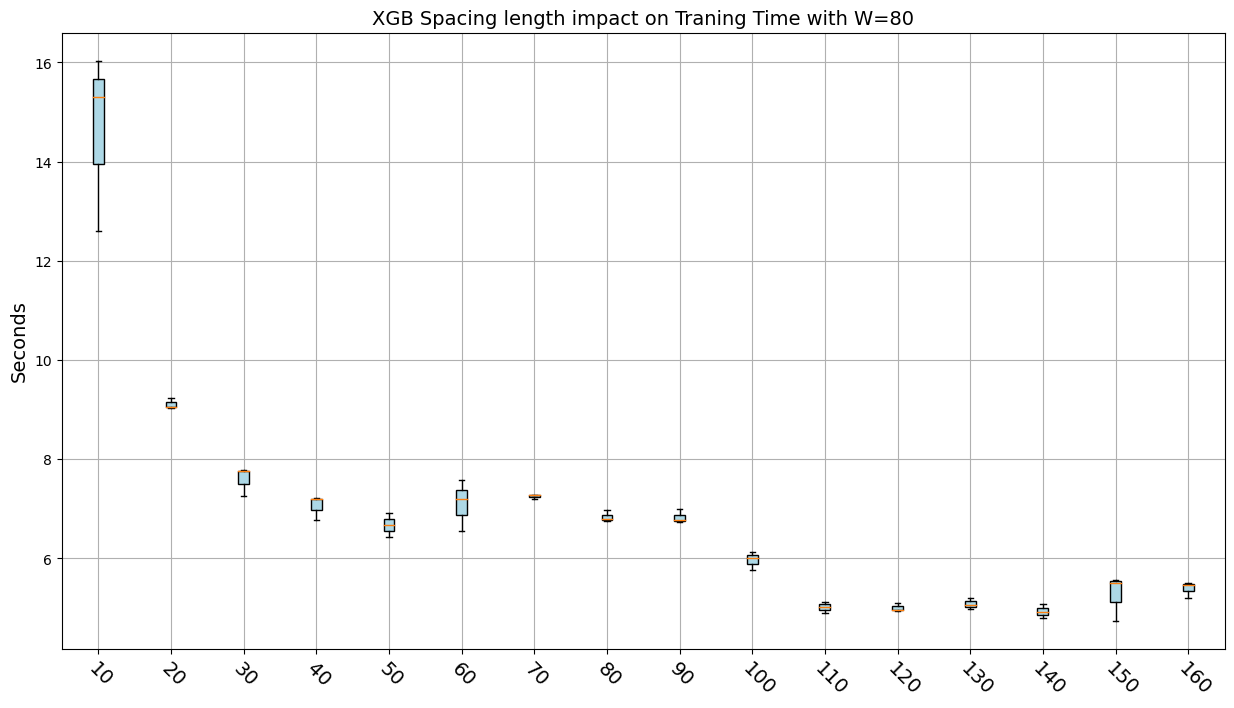

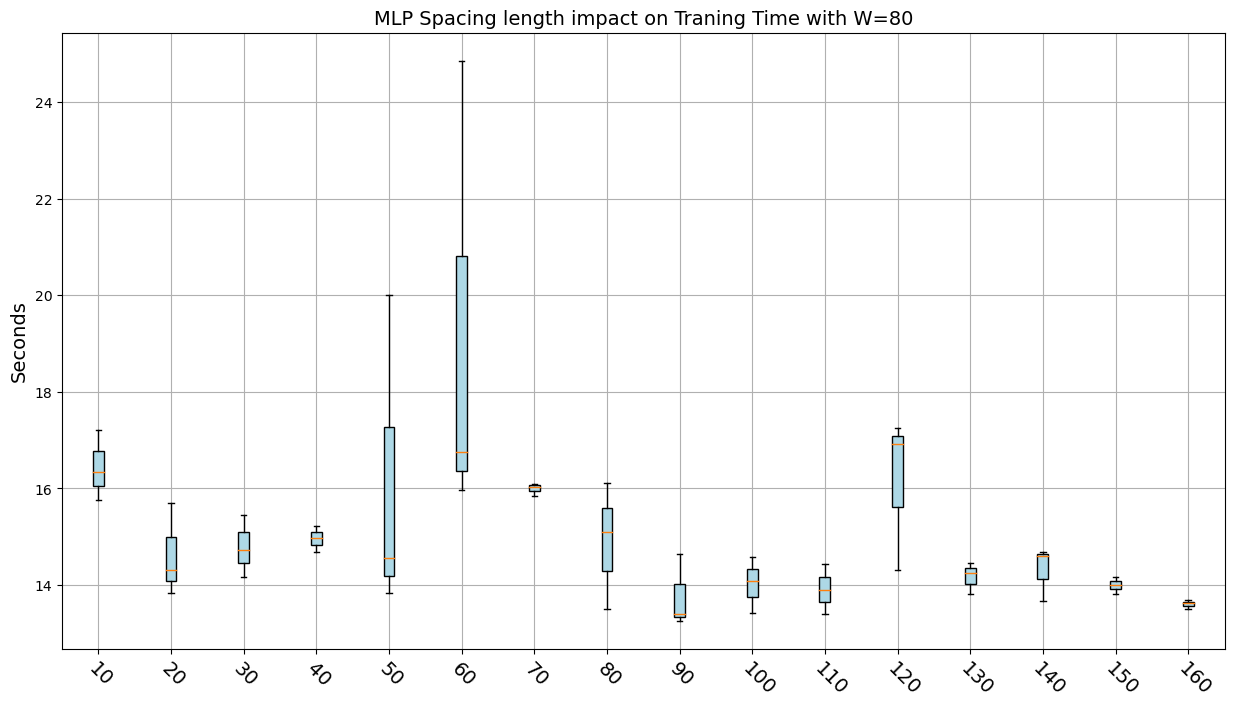

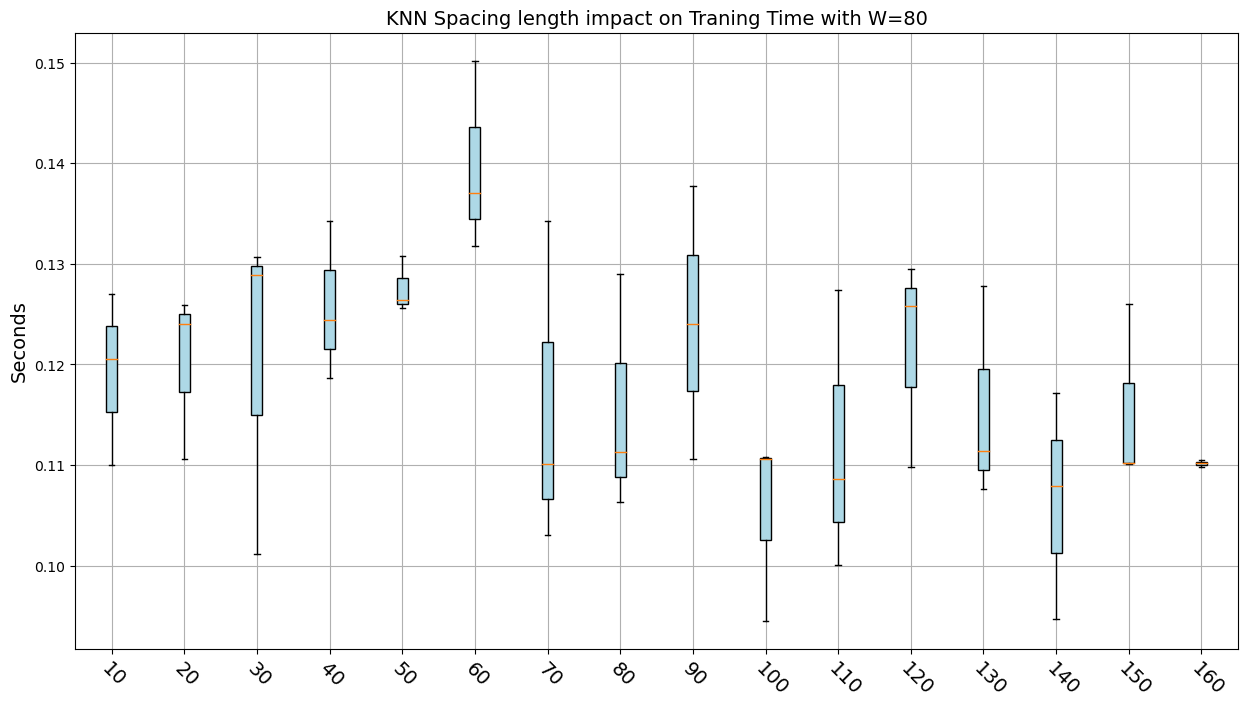

In [91]:
candle_trainng_size_impact(fig_folder, 'XGB', xgb_all_ttimes, windowrange, spacingrange)
candle_trainng_size_impact(fig_folder, 'MLP', dnn_all_ttimes, windowrange, spacingrange)
candle_trainng_size_impact(fig_folder, 'KNN', knn_all_ttimes, windowrange, spacingrange)

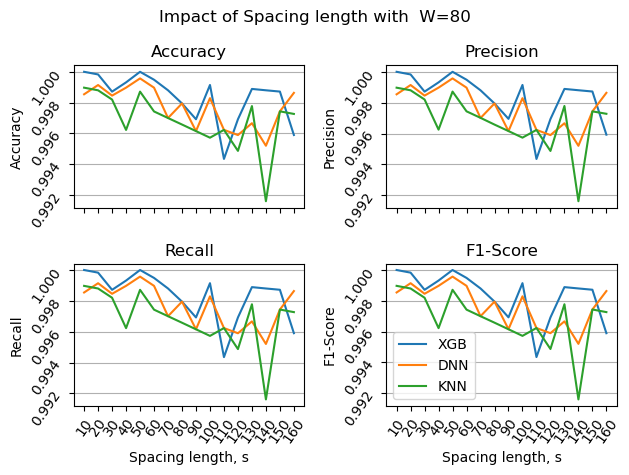

In [85]:
# Spacing Global view
draw_summary_plot(fig_folder, 0, len(A_KNN), windowrange, spacingrange)